# Outlier Detection

1. get the data
2. reshape the data
3. PCA
4. viz PCA, first 2.
5. Mahalanobis clustering analysis / outlier detection.

Troubleshoot throughout.

## Get the Data

In [57]:
import duckdb as db
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown


def get_data():
    """
    Get the data out of the db.
    """

    db_path = "/Users/jonathan/mres_thesis/wine_analysis_hplc_uv/wines.db"

    with db.connect(db_path) as con:
        data_query = """--sql
            CREATE OR REPLACE TEMP TABLE raw_shiraz AS (
            SELECT
                *
            FROM
                pbl.sample_metadata
            WHERE
                detection='raw'
            AND
              varietal='shiraz'
            ORDER BY
                sample_num
            );
            SELECT
                *
            FROM
                pbl.chromatogram_spectra_long as cs
            JOIN
            raw_shiraz
            USING
                (id)
            WHERE
                cs.mins < 30
            ORDER BY
                sample_num, idx
                ;
            """

        get_sm_query = """--sql
        select * from raw_shiraz;
        """

        data = con.sql(data_query).pl()
        sm = con.sql(get_sm_query).pl()

        return data, sm


long_data, sm = get_data()
display(Markdown("## Sample Metadata"), sm)
display(Markdown("## Sample Metadata"), long_data.head(), long_data.tail())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## Sample Metadata

detection,acq_date,wine,color,varietal,samplecode,id,sample_num
str,str,str,str,str,str,str,i64
"""raw""","""2023-02-15 19:50:05""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""10""","""a69d4665-d7b3-4706-be76-4d8e39…",6
"""raw""","""2023-02-15 23:25:01""","""2020 torbreck shiraz the strui…","""red""","""shiraz""","""15""","""744f6f00-931b-4e6d-8403-e4d302…",10
"""raw""","""2023-03-15 02:06:21""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""39""","""9a54820f-861a-41fa-8eb4-566abc…",38
"""raw""","""2023-03-21 18:53:41""","""2019 shaw and smith shiraz bal…","""red""","""shiraz""","""61""","""7f2e6628-7323-4c61-853c-2e3bc8…",60
"""raw""","""2023-03-21 19:47:21""","""2020 spinifex shiraz bete noir""","""red""","""shiraz""","""62""","""a6c0cc7f-5c1d-4360-9124-4211f4…",61
…,…,…,…,…,…,…,…
"""raw""","""2023-04-04 18:18:05""","""2020 yangarra estate shiraz mc…","""red""","""shiraz""","""82""","""7563b30e-eca5-487a-be62-31b7b3…",75
"""raw""","""2023-04-05 02:19:33""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""84""","""77a0e17d-08f2-4f44-9ad4-4f6291…",84
"""raw""","""2023-04-21 14:43:48""","""2021 chris ringland shiraz""","""red""","""shiraz""","""a0301""","""7b085f32-4d69-4f78-b49b-4d3287…",91


## Sample Metadata

idx,id,mins,wavelength,absorbance,detection,acq_date,wine,color,varietal,samplecode,sample_num
i64,str,f64,i32,f64,str,str,str,str,str,str,i64
0,"""a69d4665-d7b3-4706-be76-4d8e39…",0.003117,270,0.000037,"""raw""","""2023-02-15 19:50:05""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""10""",6
0,"""a69d4665-d7b3-4706-be76-4d8e39…",0.003117,272,-0.000149,"""raw""","""2023-02-15 19:50:05""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""10""",6
0,"""a69d4665-d7b3-4706-be76-4d8e39…",0.003117,274,-0.00269,"""raw""","""2023-02-15 19:50:05""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""10""",6
0,"""a69d4665-d7b3-4706-be76-4d8e39…",0.003117,276,-0.004753,"""raw""","""2023-02-15 19:50:05""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""10""",6
0,"""a69d4665-d7b3-4706-be76-4d8e39…",0.003117,278,-0.005938,"""raw""","""2023-02-15 19:50:05""","""2021 john duval wines shiraz c…","""red""","""shiraz""","""10""",6


idx,id,mins,wavelength,absorbance,detection,acq_date,wine,color,varietal,samplecode,sample_num
i64,str,f64,i32,f64,str,str,str,str,str,str,i64
4499,"""d4d65f88-a5db-4ac9-9dca-520fcc…",29.998533,392,0.300333,"""raw""","""2023-05-09 05:54:23""","""2022 bleeding heart shiraz""","""red""","""shiraz""","""115""",103
4499,"""d4d65f88-a5db-4ac9-9dca-520fcc…",29.998533,394,0.310637,"""raw""","""2023-05-09 05:54:23""","""2022 bleeding heart shiraz""","""red""","""shiraz""","""115""",103
4499,"""d4d65f88-a5db-4ac9-9dca-520fcc…",29.998533,396,0.31013,"""raw""","""2023-05-09 05:54:23""","""2022 bleeding heart shiraz""","""red""","""shiraz""","""115""",103
4499,"""d4d65f88-a5db-4ac9-9dca-520fcc…",29.998533,398,0.3016,"""raw""","""2023-05-09 05:54:23""","""2022 bleeding heart shiraz""","""red""","""shiraz""","""115""",103
4499,"""d4d65f88-a5db-4ac9-9dca-520fcc…",29.998533,400,0.302941,"""raw""","""2023-05-09 05:54:23""","""2022 bleeding heart shiraz""","""red""","""shiraz""","""115""",103


In [58]:
# ensure that all samples are retrieved after the join

assert sm.select("sample_num").n_unique() == long_data.select("sample_num").n_unique()


In [59]:
# check that the id column "sample_num" is a unique identifier

sample_num_grps = long_data.group_by("sample_num")
with pl.Config() as cfg:
    cfg.set_tbl_rows(11)
    display(sample_num_grps.len())

    # simple test, if any are 50% greater than the average, then there is a doubling

    outlier_lengths = sample_num_grps.len().filter(
        pl.col("len") > pl.col("len").mean().mul(1.5)
    )
    assert (
        outlier_lengths.is_empty()
    ), f"outlier sample signal length detected: {outlier_lengths}"


sample_num,len
i64,u32
99,477000
103,477000
91,477000
38,477000
84,477000
75,477000
61,477000
6,477000
67,477000


In [60]:
# inspect data.
display(long_data.describe())


statistic,idx,id,mins,wavelength,absorbance,detection,acq_date,wine,color,varietal,samplecode,sample_num
str,f64,str,f64,f64,f64,str,str,str,str,str,str,f64
"""count""",5.247e6,"""5247000""",5.247e6,5.247e6,5.247e6,"""5247000""","""5247000""","""5247000""","""5247000""","""5247000""","""5247000""",5.247e6
"""null_count""",0.0,"""0""",0.0,0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""",0.0
"""mean""",2249.5,null,15.000639,295.0,66.650546,null,null,null,null,null,null,63.090909
"""std""",1299.038197,null,8.660255,61.196411,211.556568,null,null,null,null,null,null,31.589571
"""min""",0.0,"""744f6f00-931b-4e6d-8403-e4d302…",0.00125,190.0,-25.416985,"""raw""","""2023-02-15 19:50:05""","""2014 shaw and smith shiraz""","""red""","""shiraz""","""10""",6.0
"""25%""",1125.0,null,7.50125,242.0,2.009831,null,null,null,null,null,null,38.0
"""50%""",2250.0,null,15.00125,296.0,7.303931,null,null,null,null,null,null,67.0
"""75%""",3374.0,null,22.499783,348.0,26.665136,null,null,null,null,null,null,91.0
"""max""",4499.0,"""d4d65f88-a5db-4ac9-9dca-520fcc…",29.999783,400.0,2334.782571,"""raw""","""2023-05-09 05:54:23""","""2022 clonakilla shiraz oriada""","""red""","""shiraz""","""a0301""",103.0


Text(0.5, 0.98, 'HPLC-DAD Shiraz @ 256nm')

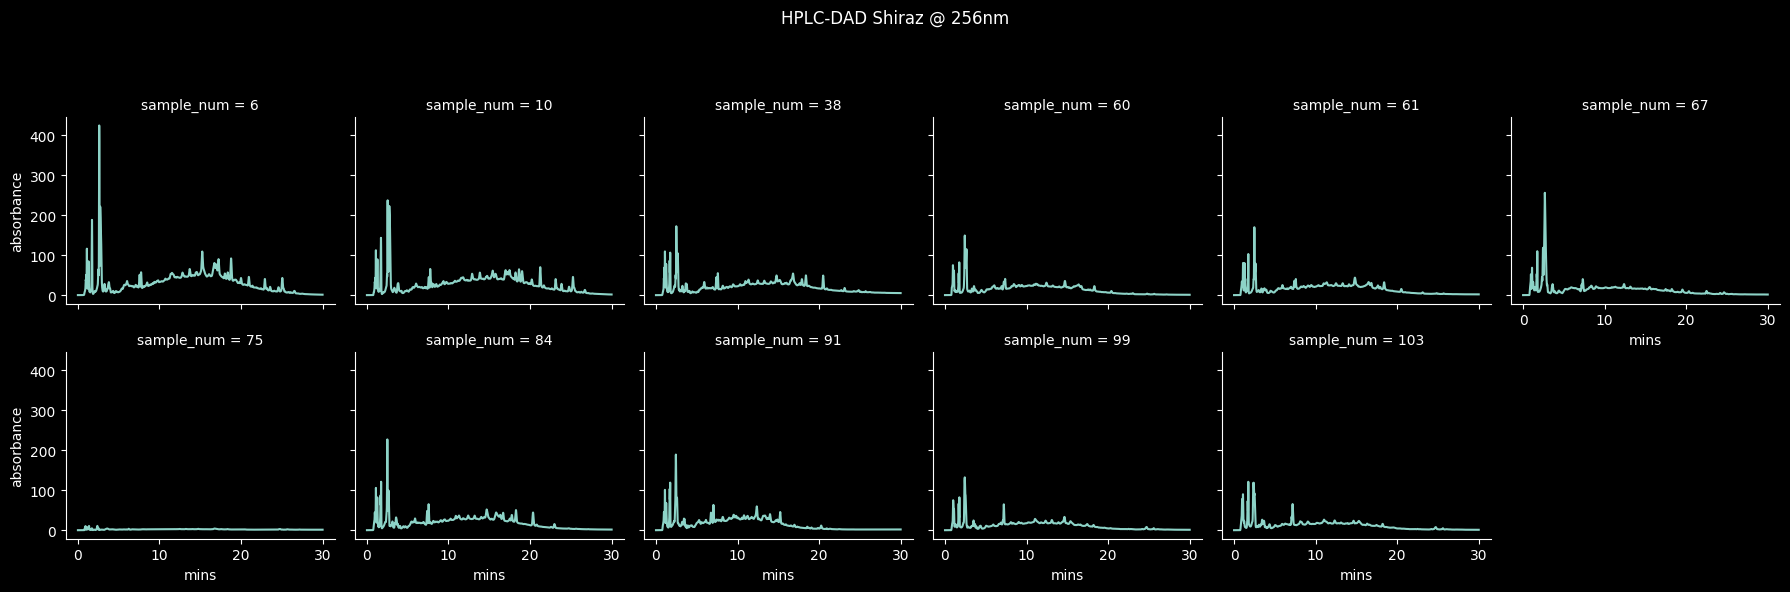

In [61]:
# display the data

import seaborn as sns

rp = sns.relplot(
    data=long_data.filter(pl.col("wavelength").eq(256)),
    x="mins",
    y="absorbance",
    col="sample_num",
    col_wrap=6,
    kind="line",
    height=3,
)
title = "HPLC-DAD Shiraz @ 256nm"
rp.figure.subplots_adjust(top=0.8)
plt.suptitle(title)


As we can see, sample 75 is obviously an outlier and easily considered a failed run. We will leave it in to see whether the outlier detection behaves as expected.